Can we back into the same adversary prediction abilities using only the sorted edge weights? I.e. if we just look at the top n edges in the filtration, is this good enough? Or do we actually use persistent homology effectively?

In [1]:
import os
import parse
import pickle
import copy
import math

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import cross_val_score
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.simple_mnist import CFF

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']

In [3]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [4]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/lbfgsm/cff_mnist_relu.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [5]:
def create_sample_graph(f):
    m = dion.homology_persistence(f)
    dgms = dion.init_diagrams(m,f)
    subgraphs = {}
    for i,c in enumerate(m):
        if len(c) == 2:
#                 print(" + ".join(["%d * %s" % (x.element, f[x.index]) for x in c]))
            if f[c[0].index][0] in subgraphs:
                subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(f[c[0].index][0]):
                        v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                    subgraphs[f[c[0].index][0]] = g

    return subgraphs, dgms[0]


def create_lifetimes(dgms):
    return [[pt.birth - pt.death for pt in dgm if pt.death < np.inf] for dgm in dgms]

In [6]:
def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams

In [7]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/cff_mnist_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [8]:
res_df, sample_graphs, dgms = create_subgraphs(model, 1, 2000)

Filtration: 0
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 65841
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 87895
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 43064
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 99318
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76795
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 48402
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79645
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69799
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96099
Sorting filtration...
Filtration: 9
h1_id_start 78

h2_id_start 3664
h3_id_start 3714
filtration size 79358
Sorting filtration...
Filtration: 76
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 75525
Sorting filtration...
Filtration: 77
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80437
Sorting filtration...
Filtration: 78
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 63975
Sorting filtration...
Filtration: 79
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 94328
Sorting filtration...
Filtration: 80
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64347
Sorting filtration...
Filtration: 81
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80986
Sorting filtration...
Filtration: 82
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 99704
Sorting filtration...
Filtration: 83
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64041
Sorting filtration...
Filtration: 84
h1_id_start 784
h2_id_start 3664
h3

Filtration: 150
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80327
Sorting filtration...
Filtration: 151
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 103338
Sorting filtration...
Filtration: 152
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 75934
Sorting filtration...
Filtration: 153
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79663
Sorting filtration...
Filtration: 154
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 44400
Sorting filtration...
Filtration: 155
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96622
Sorting filtration...
Filtration: 156
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 72396
Sorting filtration...
Filtration: 157
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80728
Sorting filtration...
Filtration: 158
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 84131
Sorting filtration...
Filtratio

Filtration: 225
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 99509
Sorting filtration...
Filtration: 226
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 98110
Sorting filtration...
Filtration: 227
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 59977
Sorting filtration...
Filtration: 228
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 44679
Sorting filtration...
Filtration: 229
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 51393
Sorting filtration...
Filtration: 230
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 77655
Sorting filtration...
Filtration: 231
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 74392
Sorting filtration...
Filtration: 232
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 88857
Sorting filtration...
Filtration: 233
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 89492
Sorting filtration...
Filtration

h3_id_start 3714
filtration size 83578
Sorting filtration...
Filtration: 300
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 65778
Sorting filtration...
Filtration: 301
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 90182
Sorting filtration...
Filtration: 302
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 45785
Sorting filtration...
Filtration: 303
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79107
Sorting filtration...
Filtration: 304
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 77582
Sorting filtration...
Filtration: 305
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 105703
Sorting filtration...
Filtration: 306
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76450
Sorting filtration...
Filtration: 307
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 70737
Sorting filtration...
Filtration: 308
h1_id_start 784
h2_id_start 3664
h3_id_sta

Filtration: 374
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 84714
Sorting filtration...
Filtration: 375
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 88343
Sorting filtration...
Filtration: 376
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 61743
Sorting filtration...
Filtration: 377
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 39758
Sorting filtration...
Filtration: 378
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 46502
Sorting filtration...
Filtration: 379
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 74716
Sorting filtration...
Filtration: 380
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 103800
Sorting filtration...
Filtration: 381
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 74721
Sorting filtration...
Filtration: 382
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 85575
Sorting filtration...
Filtratio

h3_id_start 3714
filtration size 82707
Sorting filtration...
Filtration: 449
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 114521
Sorting filtration...
Filtration: 450
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 93012
Sorting filtration...
Filtration: 451
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 100336
Sorting filtration...
Filtration: 452
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79656
Sorting filtration...
Filtration: 453
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 107095
Sorting filtration...
Filtration: 454
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76892
Sorting filtration...
Filtration: 455
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 51057
Sorting filtration...
Filtration: 456
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 73180
Sorting filtration...
Filtration: 457
h1_id_start 784
h2_id_start 3664
h3_id_s

Filtration: 523
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 53146
Sorting filtration...
Filtration: 524
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 97838
Sorting filtration...
Filtration: 525
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 98897
Sorting filtration...
Filtration: 526
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 90036
Sorting filtration...
Filtration: 527
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 121178
Sorting filtration...
Filtration: 528
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 86825
Sorting filtration...
Filtration: 529
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 53499
Sorting filtration...
Filtration: 530
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69518
Sorting filtration...
Filtration: 531
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69669
Sorting filtration...
Filtratio

h3_id_start 3714
filtration size 83960
Sorting filtration...
Filtration: 598
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 73506
Sorting filtration...
Filtration: 599
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 83429
Sorting filtration...
Filtration: 600
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76043
Sorting filtration...
Filtration: 601
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 77618
Sorting filtration...
Filtration: 602
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 101637
Sorting filtration...
Filtration: 603
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80951
Sorting filtration...
Filtration: 604
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80165
Sorting filtration...
Filtration: 605
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 71530
Sorting filtration...
Filtration: 606
h1_id_start 784
h2_id_start 3664
h3_id_sta

Filtration: 672
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 47828
Sorting filtration...
Filtration: 673
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96785
Sorting filtration...
Filtration: 674
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 82923
Sorting filtration...
Filtration: 675
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 44311
Sorting filtration...
Filtration: 676
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 87557
Sorting filtration...
Filtration: 677
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 110260
Sorting filtration...
Filtration: 678
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 84344
Sorting filtration...
Filtration: 679
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 56634
Sorting filtration...
Filtration: 680
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 85390
Sorting filtration...
Filtratio

h3_id_start 3714
filtration size 63045
Sorting filtration...
Filtration: 747
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 84335
Sorting filtration...
Filtration: 748
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 75146
Sorting filtration...
Filtration: 749
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 39308
Sorting filtration...
Filtration: 750
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92155
Sorting filtration...
Filtration: 751
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 123281
Sorting filtration...
Filtration: 752
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 83762
Sorting filtration...
Filtration: 753
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 87450
Sorting filtration...
Filtration: 754
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 44138
Sorting filtration...
Filtration: 755
h1_id_start 784
h2_id_start 3664
h3_id_sta

Filtration: 821
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 91980
Sorting filtration...
Filtration: 822
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79238
Sorting filtration...
Filtration: 823
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 107033
Sorting filtration...
Filtration: 824
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 44228
Sorting filtration...
Filtration: 825
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 75975
Sorting filtration...
Filtration: 826
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 49313
Sorting filtration...
Filtration: 827
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 73068
Sorting filtration...
Filtration: 828
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96633
Sorting filtration...
Filtration: 829
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 77655
Sorting filtration...
Filtratio

h3_id_start 3714
filtration size 99994
Sorting filtration...
Filtration: 896
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 99114
Sorting filtration...
Filtration: 897
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92142
Sorting filtration...
Filtration: 898
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79850
Sorting filtration...
Filtration: 899
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 105375
Sorting filtration...
Filtration: 900
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 53558
Sorting filtration...
Filtration: 901
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 82030
Sorting filtration...
Filtration: 902
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69867
Sorting filtration...
Filtration: 903
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 101106
Sorting filtration...
Filtration: 904
h1_id_start 784
h2_id_start 3664
h3_id_st

Filtration: 970
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80643
Sorting filtration...
Filtration: 971
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 86016
Sorting filtration...
Filtration: 972
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 106238
Sorting filtration...
Filtration: 973
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92516
Sorting filtration...
Filtration: 974
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92778
Sorting filtration...
Filtration: 975
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96518
Sorting filtration...
Filtration: 976
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76948
Sorting filtration...
Filtration: 977
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 54073
Sorting filtration...
Filtration: 978
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 89975
Sorting filtration...
Filtratio

Filtration: 1044
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 83026
Sorting filtration...
Filtration: 1045
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64285
Sorting filtration...
Filtration: 1046
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69888
Sorting filtration...
Filtration: 1047
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 98059
Sorting filtration...
Filtration: 1048
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80135
Sorting filtration...
Filtration: 1049
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 94213
Sorting filtration...
Filtration: 1050
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92867
Sorting filtration...
Filtration: 1051
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 88111
Sorting filtration...
Filtration: 1052
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 100274
Sorting filtration...


Filtration: 1118
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 95580
Sorting filtration...
Filtration: 1119
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 93720
Sorting filtration...
Filtration: 1120
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 73799
Sorting filtration...
Filtration: 1121
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92729
Sorting filtration...
Filtration: 1122
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 49352
Sorting filtration...
Filtration: 1123
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 94289
Sorting filtration...
Filtration: 1124
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 72761
Sorting filtration...
Filtration: 1125
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 78321
Sorting filtration...
Filtration: 1126
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 77386
Sorting filtration...
F

Filtration: 1192
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64539
Sorting filtration...
Filtration: 1193
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 46466
Sorting filtration...
Filtration: 1194
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96634
Sorting filtration...
Filtration: 1195
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92012
Sorting filtration...
Filtration: 1196
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 75223
Sorting filtration...
Filtration: 1197
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 82992
Sorting filtration...
Filtration: 1198
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 86258
Sorting filtration...
Filtration: 1199
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 89544
Sorting filtration...
Filtration: 1200
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 77122
Sorting filtration...
F

Filtration: 1266
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 86904
Sorting filtration...
Filtration: 1267
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92173
Sorting filtration...
Filtration: 1268
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 88457
Sorting filtration...
Filtration: 1269
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 67485
Sorting filtration...
Filtration: 1270
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69735
Sorting filtration...
Filtration: 1271
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 105318
Sorting filtration...
Filtration: 1272
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 108292
Sorting filtration...
Filtration: 1273
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 95590
Sorting filtration...
Filtration: 1274
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 59671
Sorting filtration...

h2_id_start 3664
h3_id_start 3714
filtration size 88155
Sorting filtration...
Filtration: 1341
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96176
Sorting filtration...
Filtration: 1342
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 82336
Sorting filtration...
Filtration: 1343
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64689
Sorting filtration...
Filtration: 1344
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 69474
Sorting filtration...
Filtration: 1345
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 68763
Sorting filtration...
Filtration: 1346
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64748
Sorting filtration...
Filtration: 1347
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 67890
Sorting filtration...
Filtration: 1348
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 109187
Sorting filtration...
Filtration: 1349
h1_id_start 784


h2_id_start 3664
h3_id_start 3714
filtration size 63611
Sorting filtration...
Filtration: 1415
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 102076
Sorting filtration...
Filtration: 1416
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 90778
Sorting filtration...
Filtration: 1417
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 84366
Sorting filtration...
Filtration: 1418
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 82053
Sorting filtration...
Filtration: 1419
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 96631
Sorting filtration...
Filtration: 1420
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 81851
Sorting filtration...
Filtration: 1421
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 86501
Sorting filtration...
Filtration: 1422
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 101624
Sorting filtration...
Filtration: 1423
h1_id_start 784

h2_id_start 3664
h3_id_start 3714
filtration size 90358
Sorting filtration...
Filtration: 1489
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 115886
Sorting filtration...
Filtration: 1490
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 95263
Sorting filtration...
Filtration: 1491
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92505
Sorting filtration...
Filtration: 1492
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76288
Sorting filtration...
Filtration: 1493
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80663
Sorting filtration...
Filtration: 1494
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 74587
Sorting filtration...
Filtration: 1495
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 56032
Sorting filtration...
Filtration: 1496
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 61996
Sorting filtration...
Filtration: 1497
h1_id_start 784


h2_id_start 3664
h3_id_start 3714
filtration size 90353
Sorting filtration...
Filtration: 1563
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 70442
Sorting filtration...
Filtration: 1564
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 57034
Sorting filtration...
Filtration: 1565
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 94789
Sorting filtration...
Filtration: 1566
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 51445
Sorting filtration...
Filtration: 1567
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 108374
Sorting filtration...
Filtration: 1568
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 95691
Sorting filtration...
Filtration: 1569
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79044
Sorting filtration...
Filtration: 1570
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 97095
Sorting filtration...
Filtration: 1571
h1_id_start 784


h2_id_start 3664
h3_id_start 3714
filtration size 72337
Sorting filtration...
Filtration: 1637
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80153
Sorting filtration...
Filtration: 1638
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 89965
Sorting filtration...
Filtration: 1639
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 85259
Sorting filtration...
Filtration: 1640
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 85889
Sorting filtration...
Filtration: 1641
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 101315
Sorting filtration...
Filtration: 1642
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 91647
Sorting filtration...
Filtration: 1643
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 51965
Sorting filtration...
Filtration: 1644
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 75361
Sorting filtration...
Filtration: 1645
h1_id_start 784


h2_id_start 3664
h3_id_start 3714
filtration size 63612
Sorting filtration...
Filtration: 1711
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92671
Sorting filtration...
Filtration: 1712
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 105585
Sorting filtration...
Filtration: 1713
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 88035
Sorting filtration...
Filtration: 1714
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 79914
Sorting filtration...
Filtration: 1715
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 45057
Sorting filtration...
Filtration: 1716
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 46902
Sorting filtration...
Filtration: 1717
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 104244
Sorting filtration...
Filtration: 1718
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 93062
Sorting filtration...
Filtration: 1719
h1_id_start 784

h2_id_start 3664
h3_id_start 3714
filtration size 58587
Sorting filtration...
Filtration: 1785
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 62964
Sorting filtration...
Filtration: 1786
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 68450
Sorting filtration...
Filtration: 1787
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 85154
Sorting filtration...
Filtration: 1788
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64831
Sorting filtration...
Filtration: 1789
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 71165
Sorting filtration...
Filtration: 1790
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 111778
Sorting filtration...
Filtration: 1791
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 44269
Sorting filtration...
Filtration: 1792
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 76766
Sorting filtration...
Filtration: 1793
h1_id_start 784


Filtration: 1858
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 80749
Sorting filtration...
Filtration: 1859
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 110676
Sorting filtration...
Filtration: 1860
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 66704
Sorting filtration...
Filtration: 1861
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 53705
Sorting filtration...
Filtration: 1862
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 60831
Sorting filtration...
Filtration: 1863
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92501
Sorting filtration...
Filtration: 1864
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 70545
Sorting filtration...
Filtration: 1865
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 71725
Sorting filtration...
Filtration: 1866
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 87141
Sorting filtration...


Filtration: 1932
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 86850
Sorting filtration...
Filtration: 1933
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 78885
Sorting filtration...
Filtration: 1934
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 47434
Sorting filtration...
Filtration: 1935
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 57408
Sorting filtration...
Filtration: 1936
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 99232
Sorting filtration...
Filtration: 1937
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 72595
Sorting filtration...
Filtration: 1938
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 70299
Sorting filtration...
Filtration: 1939
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 47178
Sorting filtration...
Filtration: 1940
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 64792
Sorting filtration...
F

In [9]:
adv_df, adv_sample_graphs, adv_dgms = create_adversary_subgraphs(model, 1, 2000, adversaries)

torch.Size([3000, 1, 28, 28]) torch.Size([3000])
Filtration: 0
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142910
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 160303
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 127625
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 144324
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 155315
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142823
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175039
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140889
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size

h2_id_start 3664
h3_id_start 3714
filtration size 173193
Sorting filtration...
Filtration: 75
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169860
Sorting filtration...
Filtration: 76
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 145092
Sorting filtration...
Filtration: 77
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151367
Sorting filtration...
Filtration: 78
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142013
Sorting filtration...
Filtration: 79
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161284
Sorting filtration...
Filtration: 80
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 159040
Sorting filtration...
Filtration: 81
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 153209
Sorting filtration...
Filtration: 82
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 176991
Sorting filtration...
Filtration: 83
h1_id_start 784
h2_id_star

h3_id_start 3714
filtration size 142842
Sorting filtration...
Filtration: 149
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 168771
Sorting filtration...
Filtration: 150
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 150951
Sorting filtration...
Filtration: 151
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 103338
Sorting filtration...
Filtration: 152
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 174905
Sorting filtration...
Filtration: 153
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 152373
Sorting filtration...
Filtration: 154
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 124889
Sorting filtration...
Filtration: 155
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175835
Sorting filtration...
Filtration: 156
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157512
Sorting filtration...
Filtration: 157
h1_id_start 784
h2_id_start 3664
h

h2_id_start 3664
h3_id_start 3714
filtration size 160390
Sorting filtration...
Filtration: 223
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 153791
Sorting filtration...
Filtration: 224
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140039
Sorting filtration...
Filtration: 225
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 162469
Sorting filtration...
Filtration: 226
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 139101
Sorting filtration...
Filtration: 227
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 130227
Sorting filtration...
Filtration: 228
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 168792
Sorting filtration...
Filtration: 229
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170250
Sorting filtration...
Filtration: 230
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 147858
Sorting filtration...
Filtration: 231
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 173981
Sorting filtration...
Filtration: 297
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 162572
Sorting filtration...
Filtration: 298
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 143173
Sorting filtration...
Filtration: 299
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170385
Sorting filtration...
Filtration: 300
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 160154
Sorting filtration...
Filtration: 301
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151334
Sorting filtration...
Filtration: 302
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 173889
Sorting filtration...
Filtration: 303
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169562
Sorting filtration...
Filtration: 304
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 147807
Sorting filtration...
Filtration: 305
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 155590
Sorting filtration...
Filtration: 371
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 149163
Sorting filtration...
Filtration: 372
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161546
Sorting filtration...
Filtration: 373
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 148982
Sorting filtration...
Filtration: 374
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169576
Sorting filtration...
Filtration: 375
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 173560
Sorting filtration...
Filtration: 376
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161941
Sorting filtration...
Filtration: 377
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 137132
Sorting filtration...
Filtration: 378
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 153185
Sorting filtration...
Filtration: 379
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 145432
Sorting filtration...
Filtration: 445
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 88881
Sorting filtration...
Filtration: 446
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 177917
Sorting filtration...
Filtration: 447
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 131010
Sorting filtration...
Filtration: 448
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 82707
Sorting filtration...
Filtration: 449
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 114521
Sorting filtration...
Filtration: 450
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 138629
Sorting filtration...
Filtration: 451
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 160906
Sorting filtration...
Filtration: 452
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 150620
Sorting filtration...
Filtration: 453
h1_id_start 784
h2_

h2_id_start 3664
h3_id_start 3714
filtration size 169415
Sorting filtration...
Filtration: 519
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170582
Sorting filtration...
Filtration: 520
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157685
Sorting filtration...
Filtration: 521
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 152262
Sorting filtration...
Filtration: 522
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165120
Sorting filtration...
Filtration: 523
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 167731
Sorting filtration...
Filtration: 524
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171353
Sorting filtration...
Filtration: 525
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 167056
Sorting filtration...
Filtration: 526
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 155325
Sorting filtration...
Filtration: 527
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 162160
Sorting filtration...
Filtration: 593
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151767
Sorting filtration...
Filtration: 594
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 178478
Sorting filtration...
Filtration: 595
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 168046
Sorting filtration...
Filtration: 596
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 156794
Sorting filtration...
Filtration: 597
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 163996
Sorting filtration...
Filtration: 598
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 162589
Sorting filtration...
Filtration: 599
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 181883
Sorting filtration...
Filtration: 600
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 167442
Sorting filtration...
Filtration: 601
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 118344
Sorting filtration...
Filtration: 667
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 114900
Sorting filtration...
Filtration: 668
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 153397
Sorting filtration...
Filtration: 669
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157098
Sorting filtration...
Filtration: 670
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 168119
Sorting filtration...
Filtration: 671
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171057
Sorting filtration...
Filtration: 672
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 167195
Sorting filtration...
Filtration: 673
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 148758
Sorting filtration...
Filtration: 674
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 154511
Sorting filtration...
Filtration: 675
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 64500
Sorting filtration...
Filtration: 741
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 124868
Sorting filtration...
Filtration: 742
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 174982
Sorting filtration...
Filtration: 743
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 144346
Sorting filtration...
Filtration: 744
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 164304
Sorting filtration...
Filtration: 745
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 160746
Sorting filtration...
Filtration: 746
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 153044
Sorting filtration...
Filtration: 747
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151883
Sorting filtration...
Filtration: 748
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 154958
Sorting filtration...
Filtration: 749
h1_id_start 784
h2

h2_id_start 3664
h3_id_start 3714
filtration size 157524
Sorting filtration...
Filtration: 815
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 146403
Sorting filtration...
Filtration: 816
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 145123
Sorting filtration...
Filtration: 817
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 172054
Sorting filtration...
Filtration: 818
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175643
Sorting filtration...
Filtration: 819
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158537
Sorting filtration...
Filtration: 820
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 180755
Sorting filtration...
Filtration: 821
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 149085
Sorting filtration...
Filtration: 822
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169968
Sorting filtration...
Filtration: 823
h1_id_start 784
h

h2_id_start 3664
h3_id_start 3714
filtration size 174754
Sorting filtration...
Filtration: 889
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 148206
Sorting filtration...
Filtration: 890
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 83195
Sorting filtration...
Filtration: 891
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 129477
Sorting filtration...
Filtration: 892
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 166286
Sorting filtration...
Filtration: 893
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 152217
Sorting filtration...
Filtration: 894
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171178
Sorting filtration...
Filtration: 895
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140533
Sorting filtration...
Filtration: 896
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 134599
Sorting filtration...
Filtration: 897
h1_id_start 784
h2

h2_id_start 3664
h3_id_start 3714
filtration size 139485
Sorting filtration...
Filtration: 963
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 100719
Sorting filtration...
Filtration: 964
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 138699
Sorting filtration...
Filtration: 965
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92639
Sorting filtration...
Filtration: 966
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 167713
Sorting filtration...
Filtration: 967
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 177115
Sorting filtration...
Filtration: 968
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 155847
Sorting filtration...
Filtration: 969
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 139496
Sorting filtration...
Filtration: 970
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 174532
Sorting filtration...
Filtration: 971
h1_id_start 784
h2

Filtration: 1036
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 160038
Sorting filtration...
Filtration: 1037
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140383
Sorting filtration...
Filtration: 1038
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157074
Sorting filtration...
Filtration: 1039
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 59404
Sorting filtration...
Filtration: 1040
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 124503
Sorting filtration...
Filtration: 1041
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 179022
Sorting filtration...
Filtration: 1042
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 117249
Sorting filtration...
Filtration: 1043
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 156721
Sorting filtration...
Filtration: 1044
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 83026
Sorting filtrati

h2_id_start 3664
h3_id_start 3714
filtration size 137795
Sorting filtration...
Filtration: 1110
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171553
Sorting filtration...
Filtration: 1111
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161548
Sorting filtration...
Filtration: 1112
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 93081
Sorting filtration...
Filtration: 1113
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170944
Sorting filtration...
Filtration: 1114
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 97348
Sorting filtration...
Filtration: 1115
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157126
Sorting filtration...
Filtration: 1116
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157036
Sorting filtration...
Filtration: 1117
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161918
Sorting filtration...
Filtration: 1118
h1_id_star

Filtration: 1183
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171125
Sorting filtration...
Filtration: 1184
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140168
Sorting filtration...
Filtration: 1185
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 149207
Sorting filtration...
Filtration: 1186
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158822
Sorting filtration...
Filtration: 1187
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 146872
Sorting filtration...
Filtration: 1188
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 152188
Sorting filtration...
Filtration: 1189
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170555
Sorting filtration...
Filtration: 1190
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 163397
Sorting filtration...
Filtration: 1191
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 133918
Sorting filtra

h2_id_start 3664
h3_id_start 3714
filtration size 146696
Sorting filtration...
Filtration: 1257
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 163355
Sorting filtration...
Filtration: 1258
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 172118
Sorting filtration...
Filtration: 1259
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 137824
Sorting filtration...
Filtration: 1260
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 46392
Sorting filtration...
Filtration: 1261
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 164698
Sorting filtration...
Filtration: 1262
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 129882
Sorting filtration...
Filtration: 1263
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169724
Sorting filtration...
Filtration: 1264
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151363
Sorting filtration...
Filtration: 1265
h1_id_sta

Filtration: 1330
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 180412
Sorting filtration...
Filtration: 1331
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 162415
Sorting filtration...
Filtration: 1332
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158037
Sorting filtration...
Filtration: 1333
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171295
Sorting filtration...
Filtration: 1334
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 140883
Sorting filtration...
Filtration: 1335
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 144684
Sorting filtration...
Filtration: 1336
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 150693
Sorting filtration...
Filtration: 1337
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157094
Sorting filtration...
Filtration: 1338
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 173218
Sorting filtra

h2_id_start 3664
h3_id_start 3714
filtration size 153634
Sorting filtration...
Filtration: 1404
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175598
Sorting filtration...
Filtration: 1405
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 171659
Sorting filtration...
Filtration: 1406
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 156550
Sorting filtration...
Filtration: 1407
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 166795
Sorting filtration...
Filtration: 1408
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175900
Sorting filtration...
Filtration: 1409
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 118913
Sorting filtration...
Filtration: 1410
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 139558
Sorting filtration...
Filtration: 1411
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 163110
Sorting filtration...
Filtration: 1412
h1_id_st

h3_id_start 3714
filtration size 165497
Sorting filtration...
Filtration: 1477
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165958
Sorting filtration...
Filtration: 1478
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 147263
Sorting filtration...
Filtration: 1479
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 147415
Sorting filtration...
Filtration: 1480
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 172367
Sorting filtration...
Filtration: 1481
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 145444
Sorting filtration...
Filtration: 1482
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 162256
Sorting filtration...
Filtration: 1483
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170200
Sorting filtration...
Filtration: 1484
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 135651
Sorting filtration...
Filtration: 1485
h1_id_start 784
h2_id_sta

Filtration: 1550
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165415
Sorting filtration...
Filtration: 1551
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 163843
Sorting filtration...
Filtration: 1552
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 154234
Sorting filtration...
Filtration: 1553
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 92185
Sorting filtration...
Filtration: 1554
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151734
Sorting filtration...
Filtration: 1555
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 173196
Sorting filtration...
Filtration: 1556
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165031
Sorting filtration...
Filtration: 1557
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 152044
Sorting filtration...
Filtration: 1558
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158258
Sorting filtrat

h2_id_start 3664
h3_id_start 3714
filtration size 143171
Sorting filtration...
Filtration: 1624
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158801
Sorting filtration...
Filtration: 1625
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 155796
Sorting filtration...
Filtration: 1626
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 151342
Sorting filtration...
Filtration: 1627
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 137524
Sorting filtration...
Filtration: 1628
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 149901
Sorting filtration...
Filtration: 1629
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 174672
Sorting filtration...
Filtration: 1630
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165564
Sorting filtration...
Filtration: 1631
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158481
Sorting filtration...
Filtration: 1632
h1_id_st

Filtration: 1697
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161570
Sorting filtration...
Filtration: 1698
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165660
Sorting filtration...
Filtration: 1699
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 164702
Sorting filtration...
Filtration: 1700
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 166741
Sorting filtration...
Filtration: 1701
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 159450
Sorting filtration...
Filtration: 1702
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 157612
Sorting filtration...
Filtration: 1703
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142258
Sorting filtration...
Filtration: 1704
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 145911
Sorting filtration...
Filtration: 1705
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 132909
Sorting filtra

h2_id_start 3664
h3_id_start 3714
filtration size 170357
Sorting filtration...
Filtration: 1771
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 137448
Sorting filtration...
Filtration: 1772
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 136700
Sorting filtration...
Filtration: 1773
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 129872
Sorting filtration...
Filtration: 1774
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 126360
Sorting filtration...
Filtration: 1775
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 135504
Sorting filtration...
Filtration: 1776
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 173292
Sorting filtration...
Filtration: 1777
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 159419
Sorting filtration...
Filtration: 1778
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165355
Sorting filtration...
Filtration: 1779
h1_id_st

Filtration: 1844
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 125260
Sorting filtration...
Filtration: 1845
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169055
Sorting filtration...
Filtration: 1846
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 149493
Sorting filtration...
Filtration: 1847
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 166046
Sorting filtration...
Filtration: 1848
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 173706
Sorting filtration...
Filtration: 1849
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 127876
Sorting filtration...
Filtration: 1850
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 133446
Sorting filtration...
Filtration: 1851
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 158788
Sorting filtration...
Filtration: 1852
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 175220
Sorting filtra

h2_id_start 3664
h3_id_start 3714
filtration size 139943
Sorting filtration...
Filtration: 1918
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 150920
Sorting filtration...
Filtration: 1919
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 170352
Sorting filtration...
Filtration: 1920
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 147094
Sorting filtration...
Filtration: 1921
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169938
Sorting filtration...
Filtration: 1922
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 131150
Sorting filtration...
Filtration: 1923
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 153165
Sorting filtration...
Filtration: 1924
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 178653
Sorting filtration...
Filtration: 1925
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161649
Sorting filtration...
Filtration: 1926
h1_id_st

Filtration: 1991
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 165937
Sorting filtration...
Filtration: 1992
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 169198
Sorting filtration...
Filtration: 1993
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161765
Sorting filtration...
Filtration: 1994
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 142984
Sorting filtration...
Filtration: 1995
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 164244
Sorting filtration...
Filtration: 1996
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 161565
Sorting filtration...
Filtration: 1997
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 130509
Sorting filtration...
Filtration: 1998
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 148686
Sorting filtration...
Filtration: 1999
h1_id_start 784
h2_id_start 3664
h3_id_start 3714
filtration size 149194
Sorting filtra

In [10]:
with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
    pickle.dump(adv_sample_graphs, f)
with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
    pickle.dump(sample_graphs, f)

# sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
# adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [11]:
lifetimes = create_lifetimes(dgms)
adv_lifetimes = create_lifetimes(adv_dgms)

Text(0.5, 0, 'Mean Lifetime')

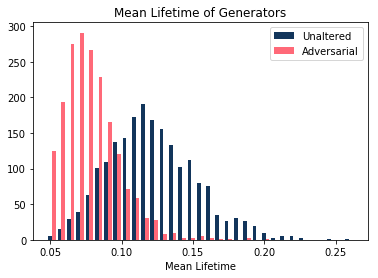

In [12]:
mls = [np.mean(l) for l in lifetimes]
adv_mls = [np.mean(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Mean Lifetime of Generators')
plt.xlabel('Mean Lifetime')

Text(0.5, 0, 'Median Lifetime')

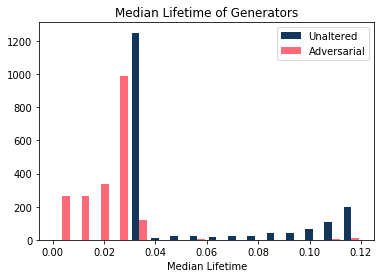

In [13]:
mls = [np.median(l) for l in lifetimes]
adv_mls = [np.median(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', range=[0,.12], color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Median Lifetime of Generators')
plt.xlabel('Median Lifetime')

In [14]:
# for dgm in dgms:
#     dion.plot.plot_diagram(dgm, show=True)

In [15]:
# for adv_dgm in adv_dgms:
#     dion.plot.plot_diagram(adv_dgm, show=True)

In [16]:
# thru = 3
# all_gois = []
# for i in range(len(sample_graphs)):
#     print(i)
#     ks = list(sample_graphs[i].keys())
#     a = [sample_graphs[i][k] for k in ks[:thru]]
#     all_gois.append(nx.compose_all(a))
    
# adv_all_gois = []
# for i in range(len(adv_sample_graphs)):
#     print(i)
#     ks = list(adv_sample_graphs[i].keys())
#     a = [adv_sample_graphs[i][k] for k in ks[:thru]]
#     adv_all_gois.append(nx.compose_all(a))

In [17]:
kernel='linear'
take = 3
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [18]:
ids = model.layerwise_ids()
ids

[range(0, 784), range(784, 3664), range(3664, 3714), range(3714, 3724)]

In [19]:
edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    lst = list(sample_graphs[i].keys())
    for k in lst[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] += 10

Sample: 0/2000
Sample: 1/2000
Sample: 2/2000
Sample: 3/2000
Sample: 4/2000
Sample: 5/2000
Sample: 6/2000
Sample: 7/2000
Sample: 8/2000
Sample: 9/2000
Sample: 10/2000
Sample: 11/2000
Sample: 12/2000
Sample: 13/2000
Sample: 14/2000
Sample: 15/2000
Sample: 16/2000
Sample: 17/2000
Sample: 18/2000
Sample: 19/2000
Sample: 20/2000
Sample: 21/2000
Sample: 22/2000
Sample: 23/2000
Sample: 24/2000
Sample: 25/2000
Sample: 26/2000
Sample: 27/2000
Sample: 28/2000
Sample: 29/2000
Sample: 30/2000
Sample: 31/2000
Sample: 32/2000
Sample: 33/2000
Sample: 34/2000
Sample: 35/2000
Sample: 36/2000
Sample: 37/2000
Sample: 38/2000
Sample: 39/2000
Sample: 40/2000
Sample: 41/2000
Sample: 42/2000
Sample: 43/2000
Sample: 44/2000
Sample: 45/2000
Sample: 46/2000
Sample: 47/2000
Sample: 48/2000
Sample: 49/2000
Sample: 50/2000
Sample: 51/2000
Sample: 52/2000
Sample: 53/2000
Sample: 54/2000
Sample: 55/2000
Sample: 56/2000
Sample: 57/2000
Sample: 58/2000
Sample: 59/2000
Sample: 60/2000
Sample: 61/2000
Sample: 62/2000
Sa

Sample: 530/2000
Sample: 531/2000
Sample: 532/2000
Sample: 533/2000
Sample: 534/2000
Sample: 535/2000
Sample: 536/2000
Sample: 537/2000
Sample: 538/2000
Sample: 539/2000
Sample: 540/2000
Sample: 541/2000
Sample: 542/2000
Sample: 543/2000
Sample: 544/2000
Sample: 545/2000
Sample: 546/2000
Sample: 547/2000
Sample: 548/2000
Sample: 549/2000
Sample: 550/2000
Sample: 551/2000
Sample: 552/2000
Sample: 553/2000
Sample: 554/2000
Sample: 555/2000
Sample: 556/2000
Sample: 557/2000
Sample: 558/2000
Sample: 559/2000
Sample: 560/2000
Sample: 561/2000
Sample: 562/2000
Sample: 563/2000
Sample: 564/2000
Sample: 565/2000
Sample: 566/2000
Sample: 567/2000
Sample: 568/2000
Sample: 569/2000
Sample: 570/2000
Sample: 571/2000
Sample: 572/2000
Sample: 573/2000
Sample: 574/2000
Sample: 575/2000
Sample: 576/2000
Sample: 577/2000
Sample: 578/2000
Sample: 579/2000
Sample: 580/2000
Sample: 581/2000
Sample: 582/2000
Sample: 583/2000
Sample: 584/2000
Sample: 585/2000
Sample: 586/2000
Sample: 587/2000
Sample: 588/20

Sample: 1068/2000
Sample: 1069/2000
Sample: 1070/2000
Sample: 1071/2000
Sample: 1072/2000
Sample: 1073/2000
Sample: 1074/2000
Sample: 1075/2000
Sample: 1076/2000
Sample: 1077/2000
Sample: 1078/2000
Sample: 1079/2000
Sample: 1080/2000
Sample: 1081/2000
Sample: 1082/2000
Sample: 1083/2000
Sample: 1084/2000
Sample: 1085/2000
Sample: 1086/2000
Sample: 1087/2000
Sample: 1088/2000
Sample: 1089/2000
Sample: 1090/2000
Sample: 1091/2000
Sample: 1092/2000
Sample: 1093/2000
Sample: 1094/2000
Sample: 1095/2000
Sample: 1096/2000
Sample: 1097/2000
Sample: 1098/2000
Sample: 1099/2000
Sample: 1100/2000
Sample: 1101/2000
Sample: 1102/2000
Sample: 1103/2000
Sample: 1104/2000
Sample: 1105/2000
Sample: 1106/2000
Sample: 1107/2000
Sample: 1108/2000
Sample: 1109/2000
Sample: 1110/2000
Sample: 1111/2000
Sample: 1112/2000
Sample: 1113/2000
Sample: 1114/2000
Sample: 1115/2000
Sample: 1116/2000
Sample: 1117/2000
Sample: 1118/2000
Sample: 1119/2000
Sample: 1120/2000
Sample: 1121/2000
Sample: 1122/2000
Sample: 11

Sample: 1595/2000
Sample: 1596/2000
Sample: 1597/2000
Sample: 1598/2000
Sample: 1599/2000
Sample: 1600/2000
Sample: 1601/2000
Sample: 1602/2000
Sample: 1603/2000
Sample: 1604/2000
Sample: 1605/2000
Sample: 1606/2000
Sample: 1607/2000
Sample: 1608/2000
Sample: 1609/2000
Sample: 1610/2000
Sample: 1611/2000
Sample: 1612/2000
Sample: 1613/2000
Sample: 1614/2000
Sample: 1615/2000
Sample: 1616/2000
Sample: 1617/2000
Sample: 1618/2000
Sample: 1619/2000
Sample: 1620/2000
Sample: 1621/2000
Sample: 1622/2000
Sample: 1623/2000
Sample: 1624/2000
Sample: 1625/2000
Sample: 1626/2000
Sample: 1627/2000
Sample: 1628/2000
Sample: 1629/2000
Sample: 1630/2000
Sample: 1631/2000
Sample: 1632/2000
Sample: 1633/2000
Sample: 1634/2000
Sample: 1635/2000
Sample: 1636/2000
Sample: 1637/2000
Sample: 1638/2000
Sample: 1639/2000
Sample: 1640/2000
Sample: 1641/2000
Sample: 1642/2000
Sample: 1643/2000
Sample: 1644/2000
Sample: 1645/2000
Sample: 1646/2000
Sample: 1647/2000
Sample: 1648/2000
Sample: 1649/2000
Sample: 16

In [20]:
edf.head()

3699-264  3702-237  3699-100  3712-3430  290-937  3387-403  434-1733  \
0       0.0       0.0       0.0        0.0      0.0       0.0       0.0   
1       0.0       0.0       0.0        0.0      0.0       0.0       0.0   
2       0.0       0.0       0.0        0.0      0.0       0.0       0.0   
3       0.0       0.0       0.0        0.0      0.0       0.0       0.0   
4       0.0       0.0       0.0        0.0      0.0       0.0       0.0   

   3693-3719  3691-3719  3711-3690    ...     3708-3722  3715-3708  3719-3702  \
0        0.0        0.0        0.0    ...           0.0        0.0        0.0   
1        0.0        0.0        0.0    ...           0.0        0.0        0.0   
2        0.0        0.0        0.0    ...           0.0        0.0        0.0   
3        0.0        0.0        0.0    ...           0.0        0.0        0.0   
4        0.0        0.0        0.0    ...           0.0        0.0        0.0   

   3692-439  3689-403  269-296  3713-3692  3699-379  406-2834  3387-317  
0       0.0       0.0      0.0        0.0       0.0       0.0       0.0  
1       0.0       0.0      0.0        0.0       0.0       0.0       0.0  
2       0.0       0.0      0.0        0.0       0.0       0.0       0.0  
3       0.0       0.0      0.0        0.0       0.0       0.0       0.0  
4       0.0       0.0      0.0        0.0       0.0       0.0       0.0  

[5 rows x 4136 columns]

In [21]:
X = edf.values
y = res_df['class'].values

In [22]:
clf = svm.SVC( decision_function_shape='ovo', kernel=kernel)
cross_val_score(clf, X, y, cv=10)

array([0.89215686, 0.90196078, 0.8817734 , 0.86699507, 0.87562189,
       0.89447236, 0.84422111, 0.88324873, 0.87244898, 0.87628866])

In [23]:
print('Natural performance: ', res_df[res_df['class'] == res_df['prediction']].shape[0]/res_df.shape[0])

Natural performance:  0.963


In [24]:
t_fit = svm.SVC(decision_function_shape='ovo', kernel=kernel).fit(X,y)

In [25]:
# take = 3
# adv_edges = set()
# for i in range(len(adv_sample_graphs)):
#     for k in list(adv_sample_graphs[i].keys())[:take]:
#         for x in adv_sample_graphs[i][k].edges(data=True):
#             edge_name = str(x[0])+'-'+str(x[1])
#             adv_edges.add(edge_name)

In [26]:
adv_edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    lst = list(adv_sample_graphs[i].keys())
    for k in lst[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            if edge_name in adv_edf.columns:
                adv_edf.iloc[i][edge_name] += 10

Sample: 0/2000
Sample: 1/2000
Sample: 2/2000
Sample: 3/2000
Sample: 4/2000
Sample: 5/2000
Sample: 6/2000
Sample: 7/2000
Sample: 8/2000
Sample: 9/2000
Sample: 10/2000
Sample: 11/2000
Sample: 12/2000
Sample: 13/2000
Sample: 14/2000
Sample: 15/2000
Sample: 16/2000
Sample: 17/2000
Sample: 18/2000
Sample: 19/2000
Sample: 20/2000
Sample: 21/2000
Sample: 22/2000
Sample: 23/2000
Sample: 24/2000
Sample: 25/2000
Sample: 26/2000
Sample: 27/2000
Sample: 28/2000
Sample: 29/2000
Sample: 30/2000
Sample: 31/2000
Sample: 32/2000
Sample: 33/2000
Sample: 34/2000
Sample: 35/2000
Sample: 36/2000
Sample: 37/2000
Sample: 38/2000
Sample: 39/2000
Sample: 40/2000
Sample: 41/2000
Sample: 42/2000
Sample: 43/2000
Sample: 44/2000
Sample: 45/2000
Sample: 46/2000
Sample: 47/2000
Sample: 48/2000
Sample: 49/2000
Sample: 50/2000
Sample: 51/2000
Sample: 52/2000
Sample: 53/2000
Sample: 54/2000
Sample: 55/2000
Sample: 56/2000
Sample: 57/2000
Sample: 58/2000
Sample: 59/2000
Sample: 60/2000
Sample: 61/2000
Sample: 62/2000
Sa

Sample: 554/2000
Sample: 555/2000
Sample: 556/2000
Sample: 557/2000
Sample: 558/2000
Sample: 559/2000
Sample: 560/2000
Sample: 561/2000
Sample: 562/2000
Sample: 563/2000
Sample: 564/2000
Sample: 565/2000
Sample: 566/2000
Sample: 567/2000
Sample: 568/2000
Sample: 569/2000
Sample: 570/2000
Sample: 571/2000
Sample: 572/2000
Sample: 573/2000
Sample: 574/2000
Sample: 575/2000
Sample: 576/2000
Sample: 577/2000
Sample: 578/2000
Sample: 579/2000
Sample: 580/2000
Sample: 581/2000
Sample: 582/2000
Sample: 583/2000
Sample: 584/2000
Sample: 585/2000
Sample: 586/2000
Sample: 587/2000
Sample: 588/2000
Sample: 589/2000
Sample: 590/2000
Sample: 591/2000
Sample: 592/2000
Sample: 593/2000
Sample: 594/2000
Sample: 595/2000
Sample: 596/2000
Sample: 597/2000
Sample: 598/2000
Sample: 599/2000
Sample: 600/2000
Sample: 601/2000
Sample: 602/2000
Sample: 603/2000
Sample: 604/2000
Sample: 605/2000
Sample: 606/2000
Sample: 607/2000
Sample: 608/2000
Sample: 609/2000
Sample: 610/2000
Sample: 611/2000
Sample: 612/20

Sample: 1096/2000
Sample: 1097/2000
Sample: 1098/2000
Sample: 1099/2000
Sample: 1100/2000
Sample: 1101/2000
Sample: 1102/2000
Sample: 1103/2000
Sample: 1104/2000
Sample: 1105/2000
Sample: 1106/2000
Sample: 1107/2000
Sample: 1108/2000
Sample: 1109/2000
Sample: 1110/2000
Sample: 1111/2000
Sample: 1112/2000
Sample: 1113/2000
Sample: 1114/2000
Sample: 1115/2000
Sample: 1116/2000
Sample: 1117/2000
Sample: 1118/2000
Sample: 1119/2000
Sample: 1120/2000
Sample: 1121/2000
Sample: 1122/2000
Sample: 1123/2000
Sample: 1124/2000
Sample: 1125/2000
Sample: 1126/2000
Sample: 1127/2000
Sample: 1128/2000
Sample: 1129/2000
Sample: 1130/2000
Sample: 1131/2000
Sample: 1132/2000
Sample: 1133/2000
Sample: 1134/2000
Sample: 1135/2000
Sample: 1136/2000
Sample: 1137/2000
Sample: 1138/2000
Sample: 1139/2000
Sample: 1140/2000
Sample: 1141/2000
Sample: 1142/2000
Sample: 1143/2000
Sample: 1144/2000
Sample: 1145/2000
Sample: 1146/2000
Sample: 1147/2000
Sample: 1148/2000
Sample: 1149/2000
Sample: 1150/2000
Sample: 11

Sample: 1564/2000
Sample: 1565/2000
Sample: 1566/2000
Sample: 1567/2000
Sample: 1568/2000
Sample: 1569/2000
Sample: 1570/2000
Sample: 1571/2000
Sample: 1572/2000
Sample: 1573/2000
Sample: 1574/2000
Sample: 1575/2000
Sample: 1576/2000
Sample: 1577/2000
Sample: 1578/2000
Sample: 1579/2000
Sample: 1580/2000
Sample: 1581/2000
Sample: 1582/2000
Sample: 1583/2000
Sample: 1584/2000
Sample: 1585/2000
Sample: 1586/2000
Sample: 1587/2000
Sample: 1588/2000
Sample: 1589/2000
Sample: 1590/2000
Sample: 1591/2000
Sample: 1592/2000
Sample: 1593/2000
Sample: 1594/2000
Sample: 1595/2000
Sample: 1596/2000
Sample: 1597/2000
Sample: 1598/2000
Sample: 1599/2000
Sample: 1600/2000
Sample: 1601/2000
Sample: 1602/2000
Sample: 1603/2000
Sample: 1604/2000
Sample: 1605/2000
Sample: 1606/2000
Sample: 1607/2000
Sample: 1608/2000
Sample: 1609/2000
Sample: 1610/2000
Sample: 1611/2000
Sample: 1612/2000
Sample: 1613/2000
Sample: 1614/2000
Sample: 1615/2000
Sample: 1616/2000
Sample: 1617/2000
Sample: 1618/2000
Sample: 16

In [27]:
adv_preds = t_fit.predict(adv_edf.values)

In [28]:
adv_preds[:5]

array([7, 2, 1, 0, 0])

In [29]:
adv_df.head()

class      loss  prediction
0      7  2.097488           3
1      2  1.839955           1
2      1  2.935034           6
3      0  1.826473           6
4      4  3.121661           9

In [30]:
adv_df.shape

(2000, 3)

In [31]:
print('Recovery Accuracy: {}'.format(adv_df[adv_df['class'] == adv_preds[:adv_df.shape[0]]].shape[0]/adv_df.shape[0]))

Recovery Accuracy: 0.5895


In [32]:
print('Adversary Class Percentage: {}'.format(adv_df[adv_df['prediction'] == adv_preds].shape[0]/adv_df.shape[0]))

Adversary Class Percentage: 0.3455


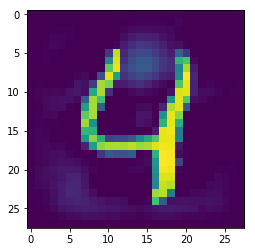

In [33]:
plt.imshow(adversaries[4]['adversary'].reshape(28,28))

In [34]:
adv_df['prediction'].value_counts()/adv_df.shape[0]

8    0.2445
9    0.1785
5    0.1210
3    0.1050
4    0.0885
1    0.0740
2    0.0630
6    0.0560
7    0.0555
0    0.0140
Name: prediction, dtype: float64

In [35]:
adv_df[adv_df['class'] == adv_preds]['prediction'].value_counts()/adv_df[adv_df['class'] == adv_preds]['prediction'].shape[0]

8    0.262935
9    0.156064
5    0.145038
3    0.093299
1    0.091603
4    0.067854
6    0.067006
2    0.058524
7    0.043257
0    0.014419
Name: prediction, dtype: float64

In [36]:
colors = ['black', 'blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'silver', 'cyan']
labels = list(range(10))

In [37]:
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import PyQt5

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)

# plt.cla()
# pca = PCA(n_components=3)
# pca.fit(X)
# X_pca = pca.transform(X)

# for i in range(len(X_pca)):
#     ax.scatter(X_pca[i,0], X_pca[i,1], X_pca[i,2], color=colors[res_df['prediction'].iloc[i]])

In [38]:
# from sklearn import manifold
# from collections import OrderedDict

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)
# plt.cla()

# # X_dimmed = manifold.TSNE(n_components=3, init='pca', random_state=0).fit_transform(X)
# X_dimmed = manifold.Isomap(10, 3).fit_transform(X)

# for i in range(len(X_dimmed)):
#     ax.scatter(X_dimmed[i,0], X_dimmed[i,1], X_dimmed[i,2], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]])

# handles, labs = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labs, handles))
# ax.legend(by_label.values(), by_label.keys())

In [39]:
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import OrderedDict
plot_take = 1000

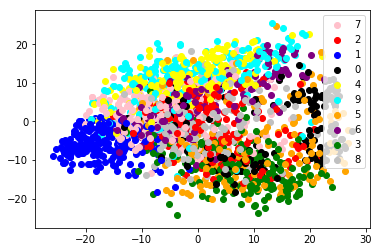

In [40]:
fig, ax = plt.subplots()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for i in range(len(X_pca)):
    ax.scatter(X_pca[i,0], X_pca[i,1], color=colors[res_df['prediction'].iloc[i]], label=labels[res_df['class'].iloc[i]])
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

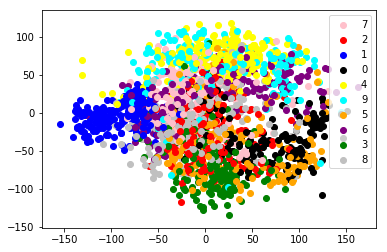

In [41]:
from sklearn import manifold
fig, ax = plt.subplots()
X_dimmed = manifold.Isomap(n_neighbors=15, n_components=2).fit_transform(X)
# X_dimmed = manifold.TSNE(n_components=2, init='pca', random_state=5).fit_transform(X)
# X_dimmed = manifold.SpectralEmbedding(n_neighbors=100, n_components=2).fit_transform(X)
# X_dimmed = manifold.MDS(2, max_iter=200, n_init=10).fit_transform(X)
# X_dimmed = manifold.LocallyLinearEmbedding(10, 2, eigen_solver='auto', method='standard').fit_transform(X)


for i in range(len(X_dimmed)):
    ax.scatter(X_dimmed[i,0], X_dimmed[i,1], color=colors[res_df['prediction'].iloc[i]], label=labels[res_df['prediction'].iloc[i]])
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())